In [1]:
import numpy as np
import scipy.io as si
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy
from netCDF4 import Dataset
import pickle
import datetime
from scipy.optimize import fmin
from scipy.signal import savgol_filter
# functions I've written
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

In [2]:
# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 36
ref_lon = 64.2

# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 40
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 4000  # 3900

In [3]:
# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 52
ge = 176
x = Glider(41, np.arange(gs, ge), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2018/sg041')
# ----------------------------------------------------------------------------------------------------------------------
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg041_2018_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 471
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge - 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0][d_in]
dac_v = dg_data['Dac_v'][0][0][0][d_in]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)

grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
z = -1 * grid
sz_g = grid.shape[0]

In [4]:
# ----------------------------------------------------------------------------------------------------------------------
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

In [5]:
# N2 (seasonal split )
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
datetime.date.fromordinal(np.int(d_time[0,0]))

datetime.date(2018, 10, 17)

In [6]:
# --- Two seasons
# - earliest date is ~ Oct 1 (736968), define winter as Nov 15 (737013) - Mar 31 (737149) 

bd1 = 737028  # nov 30
bd2 = 737090  # jan 31
bd3 = 737165  # apr 16

d_fall = np.where((time_rec_bin < bd1) & ((profile_tags < 55) | (profile_tags > 66)))[0]
d_win1 = np.where((time_rec_bin > bd1) & (time_rec_bin < bd2))[0]
d_win2 = np.where((time_rec_bin > bd2) & (time_rec_bin < bd3))[0]
d_ring = np.where((profile_tags >= 50) & (profile_tags <= 66.5))[0]

bckgrds = [d_fall, d_win1, d_win2, d_ring]
bckgrds_info = ['Fall', 'Winter1', 'Winter2', 'Ring']

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

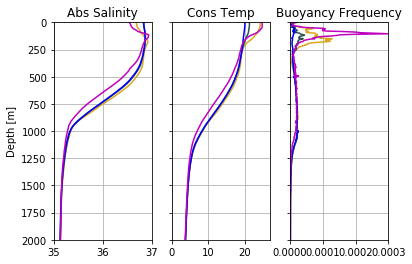

()

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#DAA520','#2F4F4F', 'b', 'm', '#2F4F4F', '#DAA520', '#DAA520'
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 2000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35, 37])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([0, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.0003])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)

In [8]:
# -------------------------------------------------------------------------------------------------
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we don't have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_transects_gamma.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_transects_gamma.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon_0 = mwe_lon[0][0:-1].copy()
dg_v_lat_0 = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon_0 = np.concatenate((dg_v_lon_0, mwe_lon[i][0:-1]))
    dg_v_lat_0 = np.concatenate((dg_v_lat_0, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1

prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)    

In [12]:
# OUTPUT 

# initial processesing (post m/w)
profile_tags  # profile list
sa  # abs sal profiles
ct  # cons temp profiles 
gamma  # neutral density profiles
time_rec_bin  # profile times 

ref_lon # reference longitude
ref_lat # reference latitude
bckgrds # time indices for splitting profiles into 4 quadrants and spitting by season 
bckgrds_info # key to above 

N2 # N2 split into backgrounds 
salin_avg # avg salin per backgrounds
cons_t_avg # avg cons temp per backgrounds
theta_avg  # avg theta per backgrounds
gamma_avg # avg gamma per backgrounds

dg_mw_time # times tagged to m/w velocity and avg dens profiles 
prof_lon_i # m/w profile longitude
prof_lat_i # m/w profile latitude 
avg_ct_per_dep # m/w avg ct per 4 profiles
avg_sa_per_dep # m/w avg sa per 4 profiles
avg_sig0_per_dep # m/w avg gamma per 4 profiles 
eta_alt  # eta gamma / ddz
eta_alt_2 # eta locally reference density / seasonal avg ddz 
eta_alt_3  # direct search for avg gamma per 4 profiles on seasonal avg gamma 
eta_per_prof # individual eta gamma / seasonal avg ddz
eta_per_prof_3 # individual search for eta gamma on seasonal avg gamma 

good_v # indices selecting good v, eta profiles 
avg_sig # avg gamma per 4 profiles selected 
eta_alt_sel = eta_alt[:, good_v]  # eta selected corresponding to definitions above 
eta_alt_sel_2 = eta_alt_2[:, good_v]
eta_alt_sel_3 = eta_alt_3[:, good_v]
dace_mw  # east component of dac 
dacn_mw  # north component of dac
dg_v  # cross track v profiles 
dg_v_e  # east component of v 
dg_v_n  # north component of v
dg_v_dive_no  # dive no roughly associated with the center dive of the m/w technique 
PE_per_mass_all # PE from indivudal eta profiles (filtered by noise criteria )

NameError: name 'gamma' is not defined

In [9]:
# ----------------------------------------------------------------------------------------------------------------------
# ----- Eta compute from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    avg_a_salin = salin_avg
    avg_c_temp = cons_t_avg
    
    if (this_time < bd1):  # fall
        t_over = 0  
    elif (this_time > bd1) & (this_time < bd2):  # winter1
        t_over = 1  
    else:  # winter2
        t_over = 2
        
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
        
    # loop over each bin depth
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]
    for j in range(1, len(grid) - 1):
        # profile density at depth j with local
        this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
        # background density with local reference pressure
        this_sigma_avg = gsw.rho(avg_a_salin[j-1:j+2], avg_c_temp[j-1:j+2], grid_p[j]) - 1000
        d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
        gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-1:j+2]))
        eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

eta_alt_0 = eta_alt.copy()

In [10]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_time = np.nanmean(d_time[:, i])

    if (this_time < bd1):  # fall
        t_over = 0  
    elif (this_time > bd1) & (this_time < bd2):  # winter 
        t_over = 1  
    else:
        t_over = 2
        
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]
d_time_all = d_time[:, np.abs(AG_all[1, :]) > 1*10**-4]
profile_tags_all = profile_tags[np.abs(AG_all[1, :]) > 1*10**-4]
eta_per_prof_all = eta_per_prof_3[:, np.abs(AG_all[1, :]) > 1*10**-4]
eta_m_per_prof_all = eta_m_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater


737067.127518
109.5
737028
737090


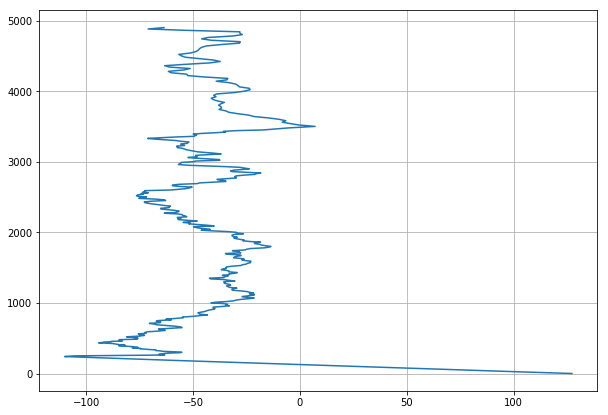

()

In [50]:
i = 115
this_time = np.nanmean(d_time[:, i])
print(this_time)
print(profile_tags[i])
print(bd1)
print(bd2)
len(profile_tags)
f, ax = plt.subplots()
ax.plot(eta_per_prof_3[:, i], grid)
plot_pro(ax)

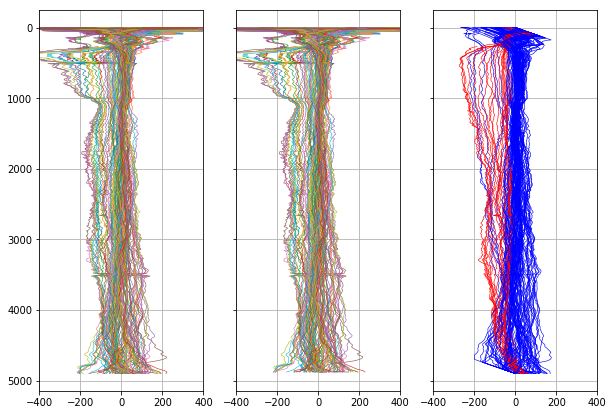

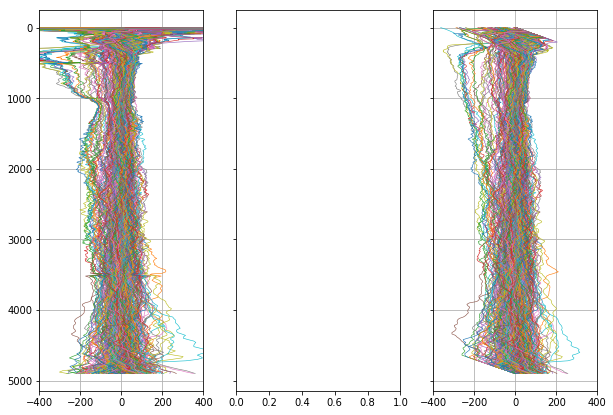

()

In [11]:
matplotlib.rcParams['figure.figsize'] = (10,7)
f, ax = plt.subplots(1, 3, sharey=True)
for i in range(np.shape(avg_sig0_per_dep)[1]):
    ax[0].plot(eta_alt[:, i], grid, linewidth=0.6)
    ax[1].plot(eta_alt_2[:, i], grid, linewidth=0.6)
    if (dg_v_dive_no_0[i] >= 50) & (dg_v_dive_no_0[i] <= 66.5):
        ax[2].plot(-1 * eta_alt_3[:, i], grid, linewidth=0.6, color='r')
    else:
        ax[2].plot(-1 * eta_alt_3[:, i], grid, linewidth=0.6, color='b')
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[1].set_xlim([-400, 400])
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

f, ax = plt.subplots(1, 3, sharey=True)
for i in range(lon.shape[1]):
    ax[0].plot(eta_per_prof[:, i], grid, linewidth=0.6)
    ax[2].plot(-1 * eta_per_prof_3[:, i], grid, linewidth=0.6)
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

In [12]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[10:-20, i], -1 * grid[10:-20])
    if (np.nanmax(np.abs(dv_dz)) < 0.004) & (np.abs(dg_v_0[200, i]) < 0.2) & (np.abs(dg_v_0[20, i]) < 0.5):
        good_v[i] = True

avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_2[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v_lon = dg_v_lon_0[good_v]
dg_v_lat = dg_v_lat_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = N2_all.copy()
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: All-NaN slice encountered


In [13]:
# SAVING 
savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'raw_profile_tags': profile_tags, 'sa': sa, 'ct': ct, 'gamma': neutral_density, 
               'lon': lon, 'lat': lat, 'dac_u': dac_u, 'dac_v': dac_v,
               'profile_time': time_rec_bin, 'ref_lon': ref_lon, 'ref_lat': ref_lat, 'background_indices': bckgrds,
               'background key': bckgrds_info, 'bd1': bd1, 'bd2': bd2, 'bd3': bd3,
               'N2_by_season_quad': N2, 'bckgrd_sa': salin_avg, 'bckgrd_ct': cons_t_avg,
               'bckgrd_theta': theta_avg, 'bckgrd_gamma': sigma_theta_avg, 'mw_time': dg_mw_time_0, 'mw_lon': prof_lon_i,
               'mw_lat': prof_lat_i, 'mw_ct': avg_ct_per_dep, 'mw_sa': avg_sa_per_dep, 'mw_gamma': avg_sig0_per_dep,
               'eta_1': eta_alt_0, 'eta_2': eta_alt_2, 'eta_3': eta_alt_3, 'eta_per_1': eta_per_prof, 
               'eta_per_3': eta_per_prof_3, 'mw_prof': dg_v_dive_no_0,
               'good_v_ind': good_v, 'mw_time_good': dg_mw_time,
               'mw_gamma_good': avg_sig, 'eta_1_good': eta_alt_0[:, good_v], 'eta_2_good': eta_alt_2[:, good_v],
               'eta_3_good': eta_alt_3[:, good_v], 'dac_e_mw': dace_mw, 'dac_n_mw': dacn_mw,
               'dg_v_good': dg_v, 'dg_v': dg_v_0, 'dg_v_e_good': dg_v_e, 'dg_v_n_good': dg_v_n, 
               'mw_prof_good': dg_v_dive_no, 'PE_per_prof': PE_per_mass_all}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_initial_processing.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

In [27]:
np.shape(sa)

(471, 248)